# Task 2: Time Series Feature Extraction with EdgeML

This notebook demonstrates how to:
1. Download sensor data from EdgeML using the Python library
2. Create sliding windows over time series data using pandas
3. Extract statistical features (mean and variance) from windows
4. Prepare features for machine learning

## 1. Install Required Libraries

First, we need to install the EdgeML Python library and other dependencies.

In [20]:
# Install edge-ml and other required packages
# Uncomment the line below if running locally
# !pip install edge-ml pandas numpy matplotlib

# If using bwjupyter.de, packages may already be installed
import sys
print(f"Python version: {sys.version}")
print("Installation complete!")

Python version: 3.10.2 (v3.10.2:a58ebcc701, Jan 13 2022, 14:50:16) [Clang 13.0.0 (clang-1300.0.29.30)]
Installation complete!


## 2. Import Libraries

Import all necessary libraries for data analysis.

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
from dotenv import load_dotenv

# Load environment variables from .env file
load_dotenv()

# EdgeML library
try:
    from edgeml import edgeml
    print("EdgeML library imported successfully")
except ImportError:
    print("Warning: EdgeML library not found. We'll use local CSV data instead.")
    edgeml = None

# Set display options for better readability
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)

print("All libraries imported successfully!")
print("Environment variables loaded from .env file")

All libraries imported successfully!


## 3. Connect to EdgeML and Download Dataset

### Option A: Using EdgeML API

In [ ]:
# EdgeML Configuration - Load from environment variables
READ_KEY = os.getenv('EDGEML_READ_KEY', 'your_read_key_here')
SERVER_URL = os.getenv('EDGEML_SERVER_URL', 'https://app.edge-ml.org')

# Attempt to connect to EdgeML and download data
if edgeml is not None:
    try:
        print(f"Connecting to EdgeML server: {SERVER_URL}")
        print(f"Using read key: {READ_KEY[:10]}...")
        
        # Create DatasetReceiver to download data
        project = edgeml.DatasetReceiver(SERVER_URL, READ_KEY)
        
        print(f"\nFound {len(project.datasets)} dataset(s) in project")
        
        if len(project.datasets) > 0:
            # Show first dataset info
            print(f"\nFirst dataset: {project.datasets[0].name}")
            print(f"Metadata: {project.datasets[0].metaData}")
            
            # Load data for the first dataset
            print("\nLoading time series data...")
            project.datasets[0].loadData()
            
            # Convert to DataFrame
            df = project.datasets[0].data
            print(f"Successfully loaded data from EdgeML")
            print(f"Data shape: {df.shape}")
            print(f"Columns: {df.columns.tolist()}")
        else:
            print("\nNo datasets found in project. Falling back to local CSV data...")
            df = None
        
    except Exception as e:
        print(f"\nError connecting to EdgeML: {e}")
        print("Falling back to local CSV data...")
        df = None
else:
    print("EdgeML library not available. Using local CSV data...")
    df = None

EdgeML library not available. Using local CSV data...


### Option B: Load CSV Data from Task 1

Use the sensor data we collected in Task 1 as an alternative.

In [23]:
# Load CSV data from Task 1 (fallback if EdgeML not available)
if df is None or df.empty:
    csv_file = '../task1/test_data.csv'
    
    try:
        df = pd.read_csv(csv_file)
        print(f"Successfully loaded data from {csv_file}")
        print(f"Data shape: {df.shape}")
    except FileNotFoundError:
        print(f"File not found: {csv_file}")
        print("Please ensure the file exists or adjust the path")
else:
    print("Using data from EdgeML (already loaded)")

Successfully loaded data from ../task1/test_data.csv
Data shape: (90, 7)


## 4. Explore the Dataset

Let's examine the structure and content of the data.

In [24]:
# Display basic information
print("Dataset Info:")
print(df.info())
print("\n" + "="*50 + "\n")

print("First few rows:")
print(df.head(10))
print("\n" + "="*50 + "\n")

print("Column names:")
print(df.columns.tolist())
print("\n" + "="*50 + "\n")

print("Data types:")
print(df.dtypes)
print("\n" + "="*50 + "\n")

print("Statistical summary:")
print(df.describe())

Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 90 entries, 0 to 89
Data columns (total 7 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Timestamp          90 non-null     int64  
 1   Relative Time (s)  90 non-null     float64
 2   Sensor Type        90 non-null     object 
 3   X                  90 non-null     float64
 4   Y                  90 non-null     float64
 5   Z                  90 non-null     float64
 6   Context            90 non-null     object 
dtypes: float64(4), int64(1), object(2)
memory usage: 5.0+ KB
None


First few rows:
       Timestamp  Relative Time (s)  Sensor Type      X      Y      Z  Context
0  1697288400000               0.00  orientation  45.23  12.45   5.67  walking
1  1697288400050               0.05  orientation  46.89  13.12  -2.34  walking
2  1697288400100               0.10  orientation  48.45  14.78   8.91  walking
3  1697288400150               0.15  orientation  4

## 5. Create Time Windows

We'll use pandas rolling windows to create overlapping time windows.
Documentation: https://pandas.pydata.org/docs/user_guide/window.html

In [25]:
# Window configuration
WINDOW_SIZE = 5  # Number of samples per window
MIN_PERIODS = 3  # Minimum samples required for calculation

print(f"Window Configuration:")
print(f"  Window size: {WINDOW_SIZE} samples")
print(f"  Minimum periods: {MIN_PERIODS} samples")
print(f"\nThis creates overlapping windows that slide through the data.")
print(f"Each window will contain {WINDOW_SIZE} consecutive samples.")

Window Configuration:
  Window size: 5 samples
  Minimum periods: 3 samples

This creates overlapping windows that slide through the data.
Each window will contain 5 consecutive samples.


## 6. Calculate Mean Features

Extract mean values from rolling windows for each sensor axis.

In [26]:
# Calculate rolling mean for X, Y, Z columns
features_mean = df.groupby('Sensor Type')[['X', 'Y', 'Z']].rolling(
    window=WINDOW_SIZE, 
    min_periods=MIN_PERIODS
).mean()

# Rename columns to indicate they are mean features
features_mean.columns = [f'{col}_mean' for col in features_mean.columns]

print("Mean Features Shape:", features_mean.shape)
print("\nFirst few mean values:")
print(features_mean.head(10))
print("\nSummary statistics of mean features:")
print(features_mean.describe())

Mean Features Shape: (90, 3)

First few mean values:
                    X_mean  Y_mean     Z_mean
Sensor Type                                  
accelerometer 30       NaN     NaN        NaN
              31       NaN     NaN        NaN
              32  0.236667   0.570   9.783333
              33  0.762500   0.485  10.060000
              34  0.320000   0.812   9.830000
              35  0.914000   0.402  10.142000
              36  0.222000   1.070   9.808000
              37  1.134000   0.334  10.274000
              38  0.110000   0.978   9.674000
              39  1.312000  -0.070  10.338000

Summary statistics of mean features:
          X_mean     Y_mean     Z_mean
count  84.000000  84.000000  84.000000
mean   15.989462   9.392599   5.025038
std    22.724939   8.143333   5.558410
min   -10.088000  -1.514000  -8.488000
25%    -0.167500   1.228000   2.138500
50%     2.146000  11.548000   7.556000
75%    45.839000  13.966000   9.111000
max    51.960000  31.224000  10.782000


## 7. Calculate Variance Features

Extract variance values from rolling windows for each sensor axis.

In [27]:
# Calculate rolling variance for X, Y, Z columns
features_var = df.groupby('Sensor Type')[['X', 'Y', 'Z']].rolling(
    window=WINDOW_SIZE, 
    min_periods=MIN_PERIODS
).var()

# Rename columns to indicate they are variance features
features_var.columns = [f'{col}_var' for col in features_var.columns]

print("Variance Features Shape:", features_var.shape)
print("\nFirst few variance values:")
print(features_var.head(10))
print("\nSummary statistics of variance features:")
print(features_var.describe())

Variance Features Shape: (90, 3)

First few variance values:
                      X_var     Y_var     Z_var
Sensor Type                                    
accelerometer 30        NaN       NaN       NaN
              31        NaN       NaN       NaN
              32   0.908133  0.847900  0.112233
              33   1.711425  0.594167  0.381000
              34   2.262600  0.980270  0.550250
              35   3.774330  1.812570  0.997970
              36   5.621970  2.620850  1.574120
              37   7.746930  4.832530  2.242830
              38   9.902450  6.738770  3.118830
              39  12.438670  9.238250  4.055070

Summary statistics of variance features:
             X_var        Y_var        Z_var
count    84.000000    84.000000    84.000000
mean    374.949295   189.140141   485.276316
std     679.841941   316.131879   623.007917
min       0.908133     0.594167     0.112233
25%      23.304247    17.683029    23.150569
50%      76.059180    58.210450   136.151540
75%   

## 8. Combine Features into DataFrame

Merge mean and variance features together for analysis.

In [28]:
# Combine mean and variance features
features_combined = pd.concat([features_mean, features_var], axis=1)

# Reset index to make Sensor Type a column
features_combined = features_combined.reset_index()

print("Combined Features Shape:", features_combined.shape)
print("\nColumn names:")
print(features_combined.columns.tolist())
print("\nFirst few rows:")
print(features_combined.head(10))
print("\nFeatures by Sensor Type:")
print(features_combined.groupby('Sensor Type').size())

Combined Features Shape: (90, 8)

Column names:
['Sensor Type', 'level_1', 'X_mean', 'Y_mean', 'Z_mean', 'X_var', 'Y_var', 'Z_var']

First few rows:
     Sensor Type  level_1    X_mean  Y_mean     Z_mean      X_var     Y_var  \
0  accelerometer       30       NaN     NaN        NaN        NaN       NaN   
1  accelerometer       31       NaN     NaN        NaN        NaN       NaN   
2  accelerometer       32  0.236667   0.570   9.783333   0.908133  0.847900   
3  accelerometer       33  0.762500   0.485  10.060000   1.711425  0.594167   
4  accelerometer       34  0.320000   0.812   9.830000   2.262600  0.980270   
5  accelerometer       35  0.914000   0.402  10.142000   3.774330  1.812570   
6  accelerometer       36  0.222000   1.070   9.808000   5.621970  2.620850   
7  accelerometer       37  1.134000   0.334  10.274000   7.746930  4.832530   
8  accelerometer       38  0.110000   0.978   9.674000   9.902450  6.738770   
9  accelerometer       39  1.312000  -0.070  10.338000  12.43

## 9. Visualize Features

Plot mean and variance features over time for each sensor type.

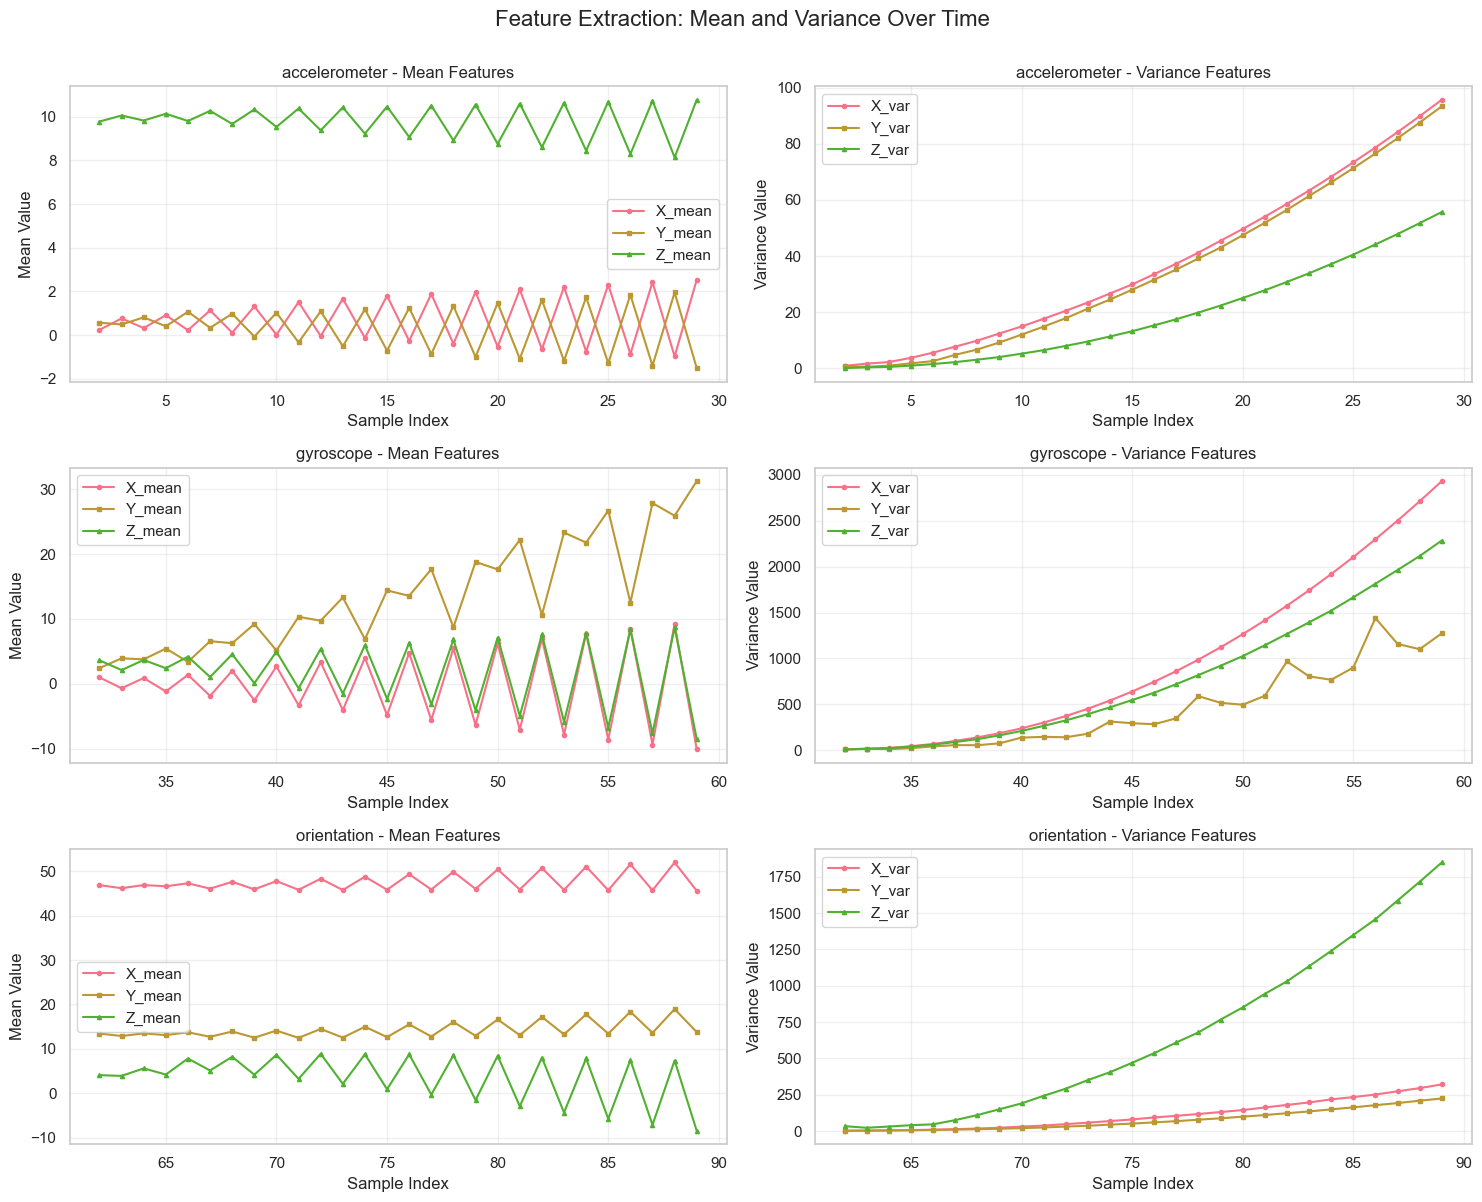


Visualization complete!
Generated 3 rows of plots (mean and variance for each sensor type)


In [29]:
# Create visualizations for each sensor type
fig, axes = plt.subplots(3, 2, figsize=(15, 12))
fig.suptitle('Feature Extraction: Mean and Variance Over Time', fontsize=16, y=1.00)

sensor_types = features_combined['Sensor Type'].unique()

for idx, sensor_type in enumerate(sensor_types):
    # Filter data for current sensor type
    sensor_data = features_combined[features_combined['Sensor Type'] == sensor_type]
    
    # Plot mean features
    ax_mean = axes[idx, 0]
    ax_mean.plot(sensor_data['X_mean'], label='X_mean', marker='o', markersize=3)
    ax_mean.plot(sensor_data['Y_mean'], label='Y_mean', marker='s', markersize=3)
    ax_mean.plot(sensor_data['Z_mean'], label='Z_mean', marker='^', markersize=3)
    ax_mean.set_title(f'{sensor_type} - Mean Features')
    ax_mean.set_xlabel('Sample Index')
    ax_mean.set_ylabel('Mean Value')
    ax_mean.legend()
    ax_mean.grid(True, alpha=0.3)
    
    # Plot variance features
    ax_var = axes[idx, 1]
    ax_var.plot(sensor_data['X_var'], label='X_var', marker='o', markersize=3)
    ax_var.plot(sensor_data['Y_var'], label='Y_var', marker='s', markersize=3)
    ax_var.plot(sensor_data['Z_var'], label='Z_var', marker='^', markersize=3)
    ax_var.set_title(f'{sensor_type} - Variance Features')
    ax_var.set_xlabel('Sample Index')
    ax_var.set_ylabel('Variance Value')
    ax_var.legend()
    ax_var.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("\nVisualization complete!")
print(f"Generated {len(sensor_types)} rows of plots (mean and variance for each sensor type)")

## 10. Export Features

Save the extracted features to a CSV file for further analysis or machine learning.

In [30]:
# Export features to CSV
output_file = 'features_extracted.csv'

try:
    features_combined.to_csv(output_file, index=False)
    print(f"Features successfully exported to: {output_file}")
    print(f"Total rows: {len(features_combined)}")
    print(f"Total columns: {len(features_combined.columns)}")
    print(f"\nColumns exported:")
    for col in features_combined.columns:
        print(f"  - {col}")
except Exception as e:
    print(f"Error exporting features: {e}")

Features successfully exported to: features_extracted.csv
Total rows: 90
Total columns: 8

Columns exported:
  - Sensor Type
  - level_1
  - X_mean
  - Y_mean
  - Z_mean
  - X_var
  - Y_var
  - Z_var


## 11. Advanced Feature Engineering

Let's create more sophisticated features by combining multiple datasets and calculating additional metrics.

### Step 1: Join All Datasets into Single DataFrame

Combine data from all sensor types into one unified dataframe for comprehensive analysis.

In [31]:
# Join all datasets into a single dataframe
# We'll pivot the data so each sensor type becomes separate columns

# Create a copy of the original data
df_unified = df.copy()

# Pivot the data: each sensor type gets its own X, Y, Z columns
df_pivot = df_unified.pivot_table(
    index='Timestamp',
    columns='Sensor Type',
    values=['X', 'Y', 'Z']
)

# Flatten the multi-level column names
df_pivot.columns = ['_'.join(col).strip() for col in df_pivot.columns.values]

# Reset index to make Timestamp a regular column
df_pivot = df_pivot.reset_index()

print("Unified DataFrame Shape:", df_pivot.shape)
print("\nColumn names after joining all sensors:")
for col in df_pivot.columns:
    print(f"  - {col}")

print("\nFirst few rows of unified data:")
print(df_pivot.head())

print("\nData types:")
print(df_pivot.dtypes)

print(f"\nTotal samples: {len(df_pivot)}")
print(f"Total features: {len(df_pivot.columns) - 1}")  # Excluding Timestamp

Unified DataFrame Shape: (30, 10)

Column names after joining all sensors:
  - Timestamp
  - X_accelerometer
  - X_gyroscope
  - X_orientation
  - Y_accelerometer
  - Y_gyroscope
  - Y_orientation
  - Z_accelerometer
  - Z_gyroscope
  - Z_orientation

First few rows of unified data:
       Timestamp  X_accelerometer  X_gyroscope  X_orientation  \
0  1697288400000             0.15         1.45          45.23   
1  1697288400050             1.23        -2.34          46.89   
2  1697288400100            -0.67         3.89          48.45   
3  1697288400150             2.34        -5.67          44.12   
4  1697288400200            -1.45         7.23          49.67   

   Y_accelerometer  Y_gyroscope  Y_orientation  Z_accelerometer  Z_gyroscope  \
0             0.82         2.89          12.45             9.78         0.67   
1            -0.45         5.67          13.12            10.12         3.45   
2             1.34        -1.23          14.78             9.45         6.78   
3    

### Step 2: Install and Import Seaborn

Seaborn provides advanced statistical visualization capabilities.

In [32]:
# Install seaborn if needed
try:
    import seaborn as sns
    print("Seaborn imported successfully")
except ImportError:
    print("Installing seaborn...")
    import sys
    import subprocess
    subprocess.check_call([sys.executable, "-m", "pip", "install", "seaborn"])
    import seaborn as sns
    print("Seaborn installed and imported")

# Set seaborn style
sns.set_theme(style="whitegrid")
sns.set_palette("husl")

print(f"Seaborn version: {sns.__version__}")

Seaborn imported successfully
Seaborn version: 0.13.2


### Step 3: Create Advanced Features (3D Magnitude)

Calculate magnitude/amplitude for acceleration and rotation vectors.

In [33]:
# Create enhanced features from the unified dataframe
df_features = df_pivot.copy()

print(f"Starting with {len(df_features.columns)} columns")
print(f"Column names: {df_features.columns.tolist()}")

# 1. Calculate 3D Acceleration Magnitude (Euclidean distance)
# Check for both capitalized and lowercase versions
if 'X_Accelerometer' in df_features.columns or 'X_accelerometer' in df_features.columns:
    x_col = 'X_Accelerometer' if 'X_Accelerometer' in df_features.columns else 'X_accelerometer'
    y_col = 'Y_Accelerometer' if 'Y_Accelerometer' in df_features.columns else 'Y_accelerometer'
    z_col = 'Z_Accelerometer' if 'Z_Accelerometer' in df_features.columns else 'Z_accelerometer'
    
    df_features['Acc_Magnitude'] = np.sqrt(
        df_features[x_col]**2 + 
        df_features[y_col]**2 + 
        df_features[z_col]**2
    )
    print("Created: Acc_Magnitude")

# 2. Calculate 3D Gyroscope Magnitude (angular velocity magnitude)
if 'X_Gyroscope' in df_features.columns or 'X_gyroscope' in df_features.columns:
    x_col = 'X_Gyroscope' if 'X_Gyroscope' in df_features.columns else 'X_gyroscope'
    y_col = 'Y_Gyroscope' if 'Y_Gyroscope' in df_features.columns else 'Y_gyroscope'
    z_col = 'Z_Gyroscope' if 'Z_Gyroscope' in df_features.columns else 'Z_gyroscope'
    
    df_features['Gyro_Magnitude'] = np.sqrt(
        df_features[x_col]**2 + 
        df_features[y_col]**2 + 
        df_features[z_col]**2
    )
    print("Created: Gyro_Magnitude")

# 3. Calculate Orientation Magnitude
if 'X_Orientation' in df_features.columns or 'X_orientation' in df_features.columns:
    x_col = 'X_Orientation' if 'X_Orientation' in df_features.columns else 'X_orientation'
    y_col = 'Y_Orientation' if 'Y_Orientation' in df_features.columns else 'Y_orientation'
    z_col = 'Z_Orientation' if 'Z_Orientation' in df_features.columns else 'Z_orientation'
    
    df_features['Orient_Magnitude'] = np.sqrt(
        df_features[x_col]**2 + 
        df_features[y_col]**2 + 
        df_features[z_col]**2
    )
    print("Created: Orient_Magnitude")

# 4. Calculate Jerk (rate of change of acceleration)
if 'Acc_Magnitude' in df_features.columns:
    # Get the correct column names for accelerometer
    x_col = 'X_Accelerometer' if 'X_Accelerometer' in df_features.columns else 'X_accelerometer'
    y_col = 'Y_Accelerometer' if 'Y_Accelerometer' in df_features.columns else 'Y_accelerometer'
    z_col = 'Z_Accelerometer' if 'Z_Accelerometer' in df_features.columns else 'Z_accelerometer'
    
    df_features['Jerk_X'] = df_features[x_col].diff()
    df_features['Jerk_Y'] = df_features[y_col].diff()
    df_features['Jerk_Z'] = df_features[z_col].diff()
    df_features['Jerk_Magnitude'] = np.sqrt(
        df_features['Jerk_X']**2 + 
        df_features['Jerk_Y']**2 + 
        df_features['Jerk_Z']**2
    )
    print("Created: Jerk features (X, Y, Z, Magnitude)")

# 5. Calculate Angular Acceleration (rate of change of gyroscope)
if 'Gyro_Magnitude' in df_features.columns:
    # Get the correct column names for gyroscope
    x_col = 'X_Gyroscope' if 'X_Gyroscope' in df_features.columns else 'X_gyroscope'
    y_col = 'Y_Gyroscope' if 'Y_Gyroscope' in df_features.columns else 'Y_gyroscope'
    z_col = 'Z_Gyroscope' if 'Z_Gyroscope' in df_features.columns else 'Z_gyroscope'
    
    df_features['AngAcc_X'] = df_features[x_col].diff()
    df_features['AngAcc_Y'] = df_features[y_col].diff()
    df_features['AngAcc_Z'] = df_features[z_col].diff()
    df_features['AngAcc_Magnitude'] = np.sqrt(
        df_features['AngAcc_X']**2 + 
        df_features['AngAcc_Y']**2 + 
        df_features['AngAcc_Z']**2
    )
    print("Created: Angular Acceleration features (X, Y, Z, Magnitude)")

# 6. Calculate total motion energy (combination of acceleration and rotation)
if 'Acc_Magnitude' in df_features.columns and 'Gyro_Magnitude' in df_features.columns:
    df_features['Total_Motion_Energy'] = df_features['Acc_Magnitude'] + df_features['Gyro_Magnitude']
    print("Created: Total_Motion_Energy")

print(f"\nEnhanced DataFrame Shape: {df_features.shape}")
print(f"New feature count: {len(df_features.columns) - len(df_pivot.columns)}")
print("\nAll feature columns:")
for col in df_features.columns:
    print(f"  - {col}")

print("\nFirst few rows with new features:")
print(df_features.head())

print("\nStatistics of magnitude features:")
magnitude_cols = [col for col in df_features.columns if 'Magnitude' in col or 'Energy' in col]
if magnitude_cols:
    print(df_features[magnitude_cols].describe())

Starting with 10 columns
Column names: ['Timestamp', 'X_accelerometer', 'X_gyroscope', 'X_orientation', 'Y_accelerometer', 'Y_gyroscope', 'Y_orientation', 'Z_accelerometer', 'Z_gyroscope', 'Z_orientation']
Created: Acc_Magnitude
Created: Gyro_Magnitude
Created: Orient_Magnitude
Created: Jerk features (X, Y, Z, Magnitude)
Created: Angular Acceleration features (X, Y, Z, Magnitude)
Created: Total_Motion_Energy

Enhanced DataFrame Shape: (30, 22)
New feature count: 12

All feature columns:
  - Timestamp
  - X_accelerometer
  - X_gyroscope
  - X_orientation
  - Y_accelerometer
  - Y_gyroscope
  - Y_orientation
  - Z_accelerometer
  - Z_gyroscope
  - Z_orientation
  - Acc_Magnitude
  - Gyro_Magnitude
  - Orient_Magnitude
  - Jerk_X
  - Jerk_Y
  - Jerk_Z
  - Jerk_Magnitude
  - AngAcc_X
  - AngAcc_Y
  - AngAcc_Z
  - AngAcc_Magnitude
  - Total_Motion_Energy

First few rows with new features:
       Timestamp  X_accelerometer  X_gyroscope  X_orientation  \
0  1697288400000             0.15     

### Step 4: Visualize Feature Space with Seaborn

Create various seaborn plots to explore relationships between features.

Creating pairplot of magnitude features...
Available magnitude features: ['Acc_Magnitude', 'Gyro_Magnitude', 'Orient_Magnitude', 'Jerk_Magnitude', 'AngAcc_Magnitude', 'Total_Motion_Energy']
All columns in df_features: ['Timestamp', 'X_accelerometer', 'X_gyroscope', 'X_orientation', 'Y_accelerometer', 'Y_gyroscope', 'Y_orientation', 'Z_accelerometer', 'Z_gyroscope', 'Z_orientation', 'Acc_Magnitude', 'Gyro_Magnitude', 'Orient_Magnitude', 'Jerk_X', 'Jerk_Y', 'Jerk_Z', 'Jerk_Magnitude', 'AngAcc_X', 'AngAcc_Y', 'AngAcc_Z', 'AngAcc_Magnitude', 'Total_Motion_Energy']


<Figure size 1500x1200 with 0 Axes>

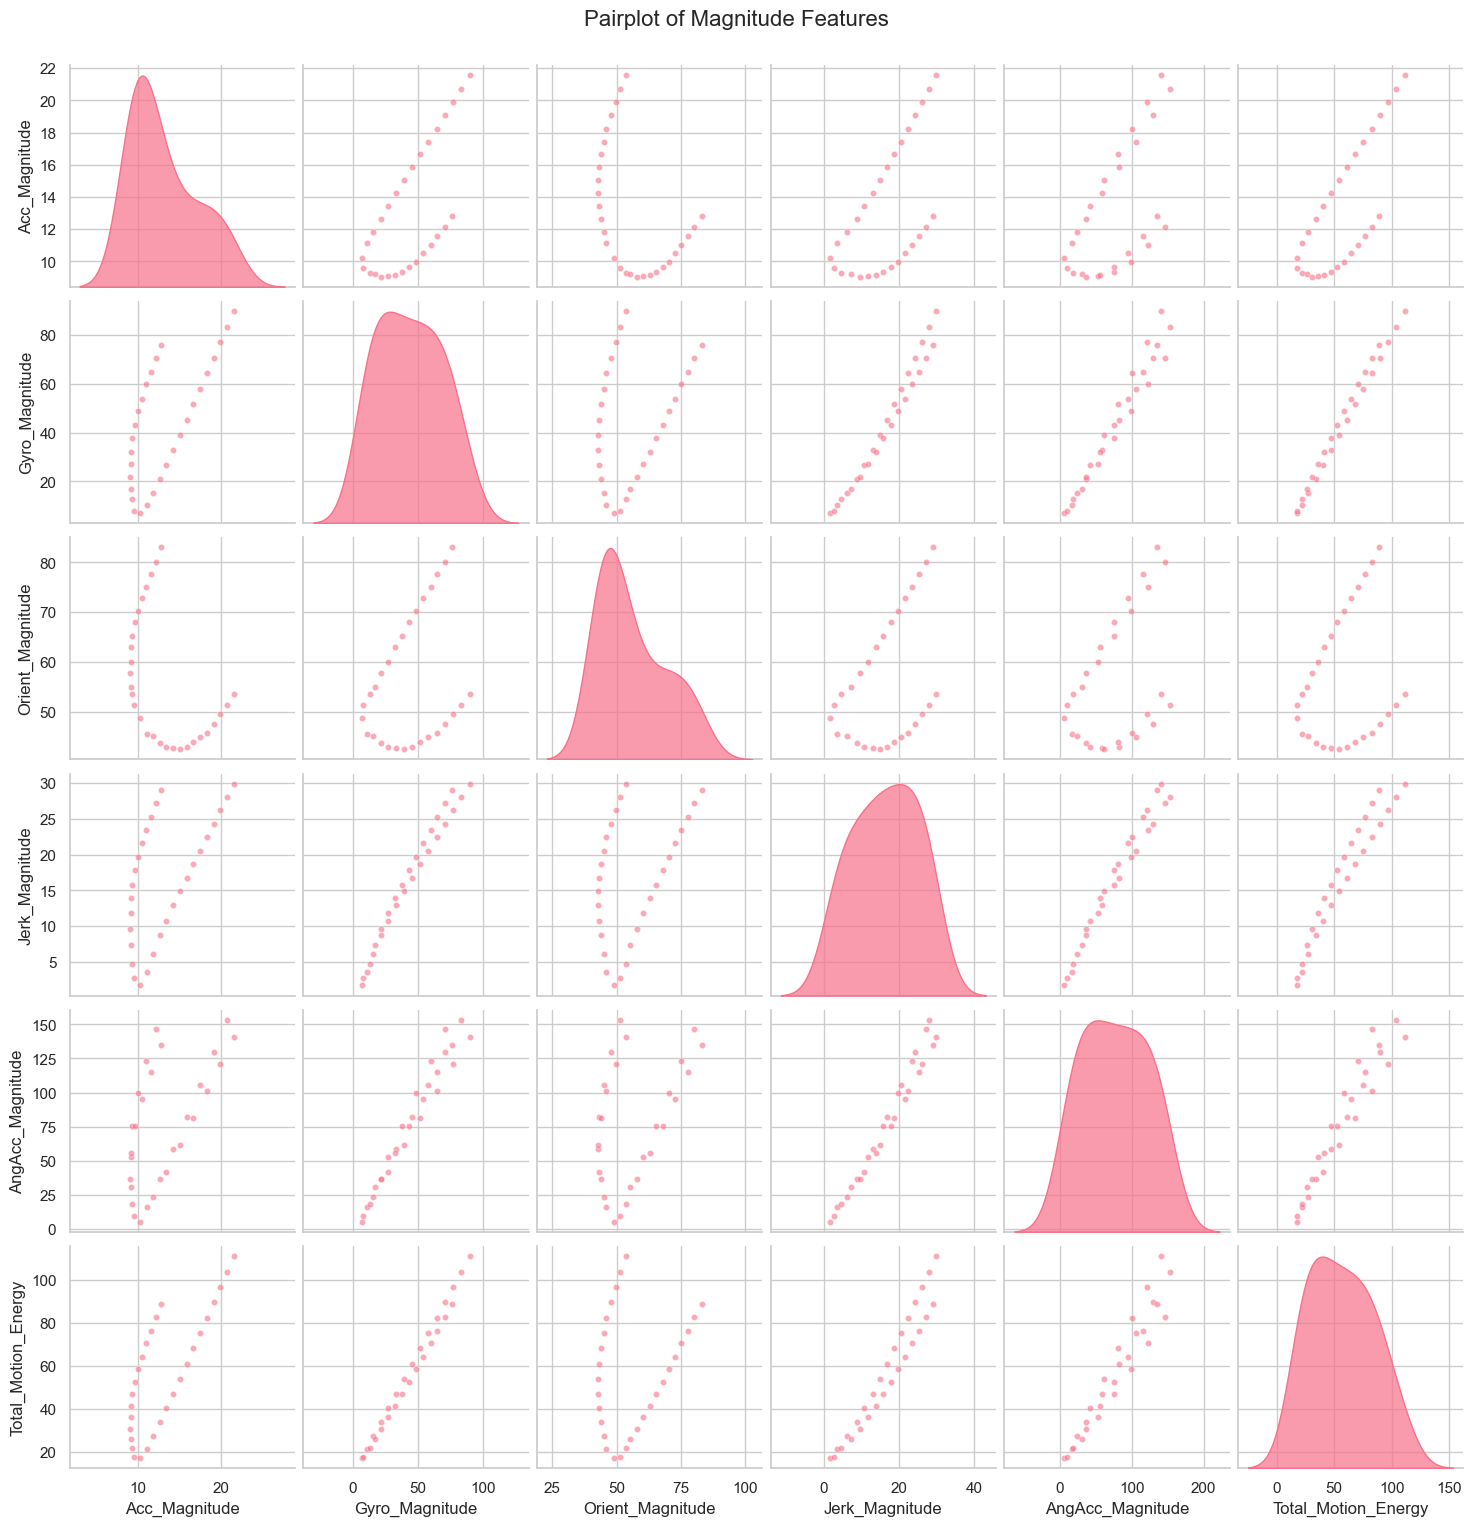

Pairplot created with 6 magnitude features


In [34]:
# Seaborn Visualization 1: Pairplot of Magnitude Features
print("Creating pairplot of magnitude features...")

# Select magnitude features for visualization
magnitude_features = ['Acc_Magnitude', 'Gyro_Magnitude', 'Orient_Magnitude', 
                      'Jerk_Magnitude', 'AngAcc_Magnitude', 'Total_Motion_Energy']

# Filter features that exist in df_features
available_magnitudes = [f for f in magnitude_features if f in df_features.columns]

print(f"Available magnitude features: {available_magnitudes}")
print(f"All columns in df_features: {df_features.columns.tolist()}")

if len(available_magnitudes) > 0:
    # Create pairplot
    fig = plt.figure(figsize=(15, 12))
    pairplot = sns.pairplot(
        df_features[available_magnitudes].dropna(),
        diag_kind='kde',
        plot_kws={'alpha': 0.6, 's': 20},
        diag_kws={'alpha': 0.7}
    )
    pairplot.fig.suptitle('Pairplot of Magnitude Features', y=1.02, fontsize=16)
    plt.show()
    print(f"Pairplot created with {len(available_magnitudes)} magnitude features")
else:
    print("No magnitude features available for pairplot")
    print("Please run Step 3 (Create Advanced Features) first!")


Creating correlation heatmap...


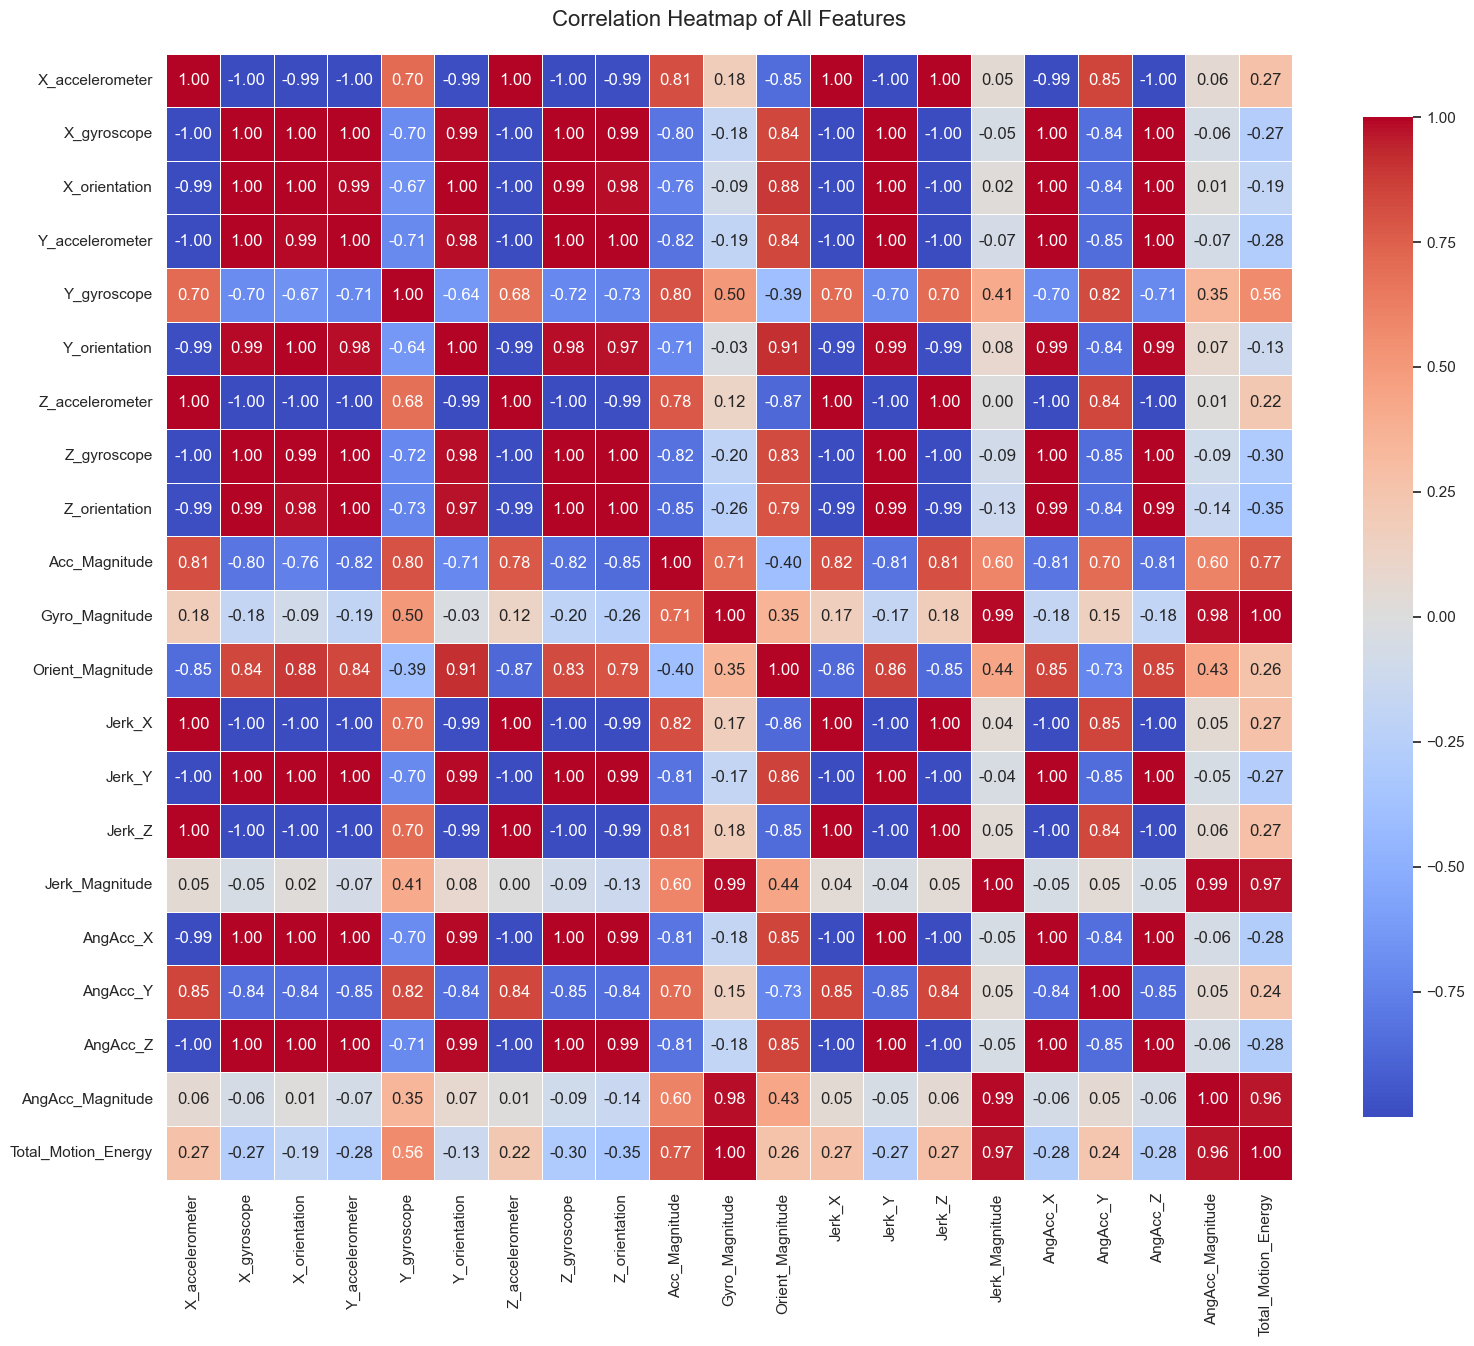

Heatmap created with 21 features


In [35]:
# Seaborn Visualization 2: Correlation Heatmap
print("\nCreating correlation heatmap...")

# Select numeric columns for correlation
numeric_cols = df_features.select_dtypes(include=[np.number]).columns.tolist()
# Remove Timestamp if it exists
numeric_cols = [col for col in numeric_cols if col != 'Timestamp']

if len(numeric_cols) > 1:
    # Calculate correlation matrix
    corr_matrix = df_features[numeric_cols].corr()
    
    # Create heatmap
    plt.figure(figsize=(16, 14))
    sns.heatmap(
        corr_matrix,
        annot=True,
        fmt='.2f',
        cmap='coolwarm',
        center=0,
        square=True,
        linewidths=0.5,
        cbar_kws={'shrink': 0.8}
    )
    plt.title('Correlation Heatmap of All Features', fontsize=16, pad=20)
    plt.tight_layout()
    plt.show()
    print(f"Heatmap created with {len(numeric_cols)} features")
else:
    print("Not enough numeric features for correlation heatmap")


Creating time series plot of magnitude features...


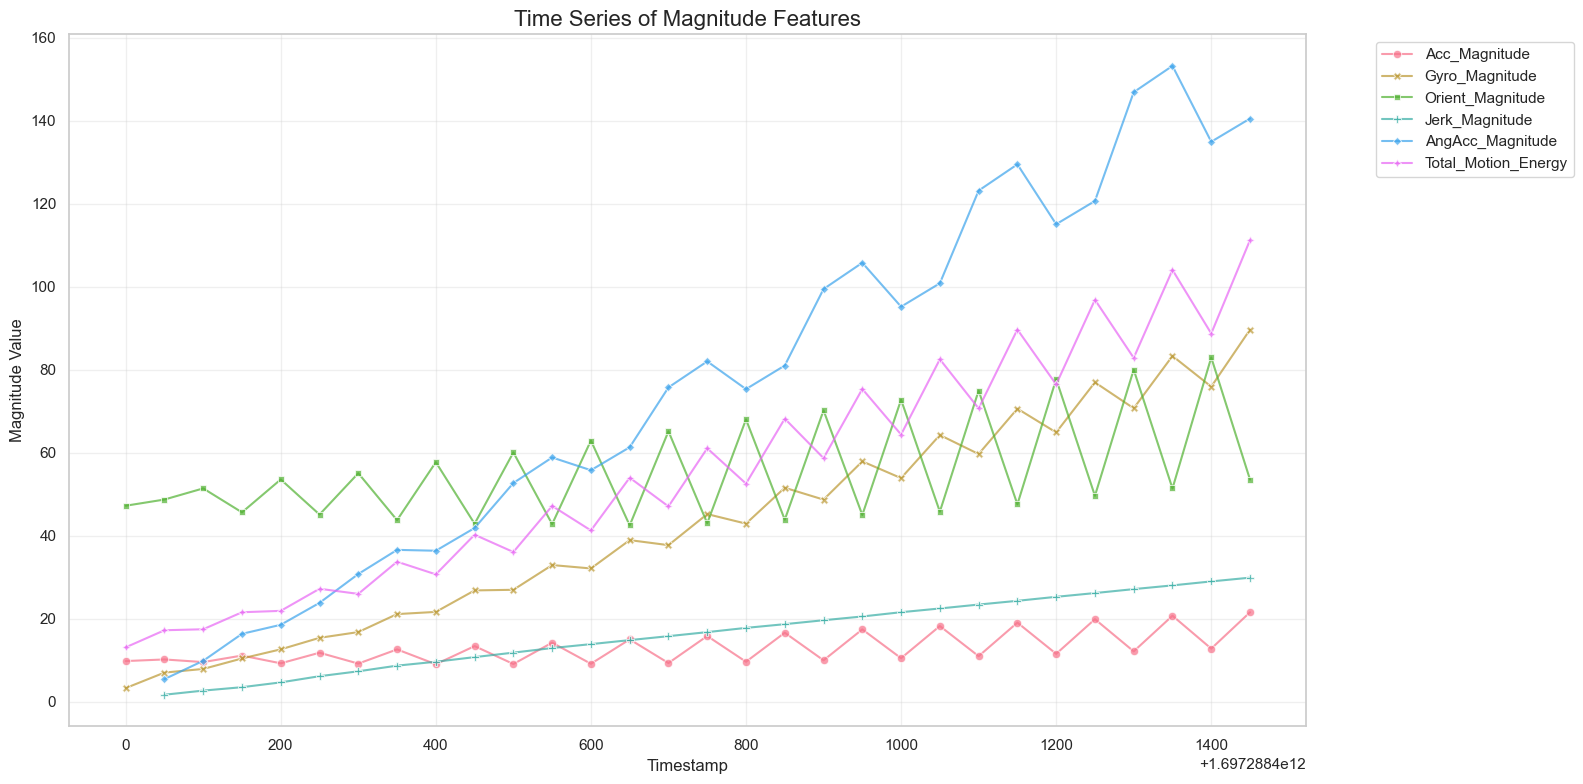

Time series plot created


In [36]:
# Seaborn Visualization 3: Time Series of Magnitude Features
print("\nCreating time series plot of magnitude features...")

# Re-define available magnitudes for this cell
magnitude_features = ['Acc_Magnitude', 'Gyro_Magnitude', 'Orient_Magnitude', 
                      'Jerk_Magnitude', 'AngAcc_Magnitude', 'Total_Motion_Energy']
available_magnitudes = [f for f in magnitude_features if f in df_features.columns]

if len(available_magnitudes) > 0:
    # Prepare data for time series plot
    df_plot = df_features[['Timestamp'] + available_magnitudes].copy()
    
    # Melt the dataframe for seaborn
    df_melted = df_plot.melt(
        id_vars=['Timestamp'],
        value_vars=available_magnitudes,
        var_name='Feature',
        value_name='Value'
    )
    
    # Create line plot
    plt.figure(figsize=(16, 8))
    sns.lineplot(
        data=df_melted,
        x='Timestamp',
        y='Value',
        hue='Feature',
        style='Feature',
        markers=True,
        dashes=False,
        alpha=0.7
    )
    plt.title('Time Series of Magnitude Features', fontsize=16)
    plt.xlabel('Timestamp')
    plt.ylabel('Magnitude Value')
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()
    print("Time series plot created")
else:
    print("No magnitude features available for time series plot")
    print("Please run Step 3 (Create Advanced Features) first!")


Creating distribution plots...


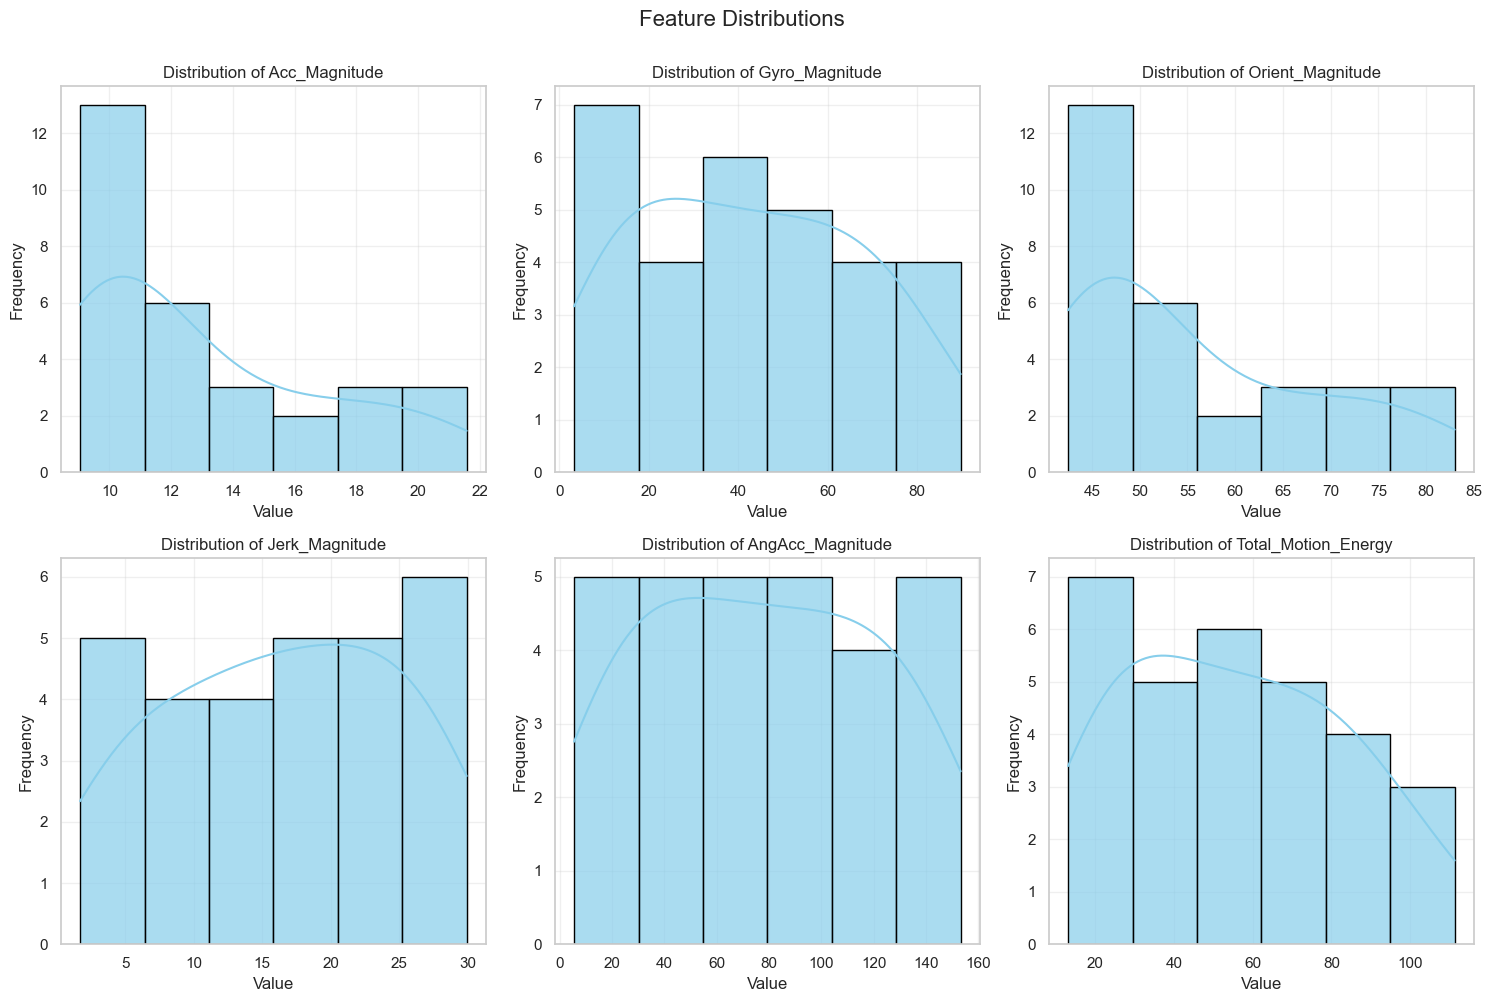

Distribution plots created for 6 features


In [37]:
# Seaborn Visualization 4: Distribution plots
print("\nCreating distribution plots...")

# Re-define available magnitudes for this cell
magnitude_features = ['Acc_Magnitude', 'Gyro_Magnitude', 'Orient_Magnitude', 
                      'Jerk_Magnitude', 'AngAcc_Magnitude', 'Total_Motion_Energy']
available_magnitudes = [f for f in magnitude_features if f in df_features.columns]

if len(available_magnitudes) > 0:
    # Create subplots for each magnitude feature
    n_features = len(available_magnitudes)
    n_cols = 3
    n_rows = (n_features + n_cols - 1) // n_cols
    
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 5 * n_rows))
    axes = axes.flatten() if n_rows > 1 else [axes] if n_cols == 1 else axes
    
    for idx, feature in enumerate(available_magnitudes):
        # Create histogram with KDE
        sns.histplot(
            data=df_features[feature].dropna(),
            kde=True,
            ax=axes[idx],
            color='skyblue',
            edgecolor='black',
            alpha=0.7
        )
        axes[idx].set_title(f'Distribution of {feature}', fontsize=12)
        axes[idx].set_xlabel('Value')
        axes[idx].set_ylabel('Frequency')
        axes[idx].grid(True, alpha=0.3)
    
    # Hide unused subplots
    for idx in range(len(available_magnitudes), len(axes)):
        axes[idx].set_visible(False)
    
    plt.suptitle('Feature Distributions', fontsize=16, y=1.00)
    plt.tight_layout()
    plt.show()
    print(f"Distribution plots created for {len(available_magnitudes)} features")
else:
    print("No magnitude features available for distribution plots")
    print("Please run Step 3 (Create Advanced Features) first!")

### Step 5: Export Enhanced Features

Save all the enhanced features for further analysis.

In [38]:
# Export enhanced features to CSV
output_enhanced = 'features_enhanced.csv'

try:
    df_features.to_csv(output_enhanced, index=False)
    print(f"Enhanced features successfully exported to: {output_enhanced}")
    print(f"Total rows: {len(df_features)}")
    print(f"Total columns: {len(df_features.columns)}")
    
    print("\n" + "="*60)
    print("SUMMARY - Advanced Feature Engineering Complete!")
    print("="*60)
    
    print("\nOriginal features:")
    print(f"  - Raw sensor data: {len(df)} rows")
    print(f"  - Sensor types: {df['Sensor Type'].nunique()}")
    
    print("\nEnhanced features created:")
    enhanced_features = [
        'Acc_Magnitude', 'Gyro_Magnitude', 'Orient_Magnitude',
        'Jerk_Magnitude', 'AngAcc_Magnitude', 'Total_Motion_Energy'
    ]
    for feat in enhanced_features:
        if feat in df_features.columns:
            print(f"  - {feat}")
    
    print(f"\nTotal feature dimensions: {len(df_features.columns)}")
    print(f"Files created:")
    print(f"  - features_extracted.csv (basic features)")
    print(f"  - features_enhanced.csv (advanced features)")
    
except Exception as e:
    print(f"Error exporting enhanced features: {e}")

Enhanced features successfully exported to: features_enhanced.csv
Total rows: 30
Total columns: 22

SUMMARY - Advanced Feature Engineering Complete!

Original features:
  - Raw sensor data: 90 rows
  - Sensor types: 3

Enhanced features created:
  - Acc_Magnitude
  - Gyro_Magnitude
  - Orient_Magnitude
  - Jerk_Magnitude
  - AngAcc_Magnitude
  - Total_Motion_Energy

Total feature dimensions: 22
Files created:
  - features_extracted.csv (basic features)
  - features_enhanced.csv (advanced features)
